# Integrations with other tools

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import mdtraj as md
traj = md.load("5550217/kras.xtc", top="5550217/kras.pdb")
topology = traj.topology

In [2]:
from contact_map import ContactFrequency

In [3]:
traj_contacts = ContactFrequency(traj)

## Exporting contact data

Contact Map Explorer makes it easy for you to get your contact data into other formats, so that you can use the tools you're already familiar with to perform your analysis. Note that the residues and atoms of these report as integers, so what you have is the index of the object in the MDTraj topology,

### SciPy sparse matrix

In [4]:
traj_contacts.residue_contacts.sparse_matrix

<219x219 sparse matrix of type '<class 'numpy.float64'>'
	with 3034 stored elements in Dictionary Of Keys format>

### Pandas dataframe

In [5]:
traj_contacts.residue_contacts.df

,0,1,2,3,4,5,6,7,8,9,...,209,210,211,212,213,214,215,216,217,218
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.019802
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.009901,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Direct access to the `Counter`

For `ContactFrequency` and `ContactDifference` you can directly access the internal [collections.Counter](https://docs.python.org/3/library/collections.html#collections.Counter) object that stores the contact frequency. This `Counter` is a mapping of a `frozenset` of the MDTraj indices (`int`s) to the frequency.

In [6]:
counter = traj_contacts.residue_contacts.counter
dict(list(counter.items())[:5])  # to illustrate a few

{frozenset({15, 57}): 0.9900990099009901,
 frozenset({150, 153}): 0.9405940594059405,
 frozenset({83, 116}): 1.0,
 frozenset({111, 154}): 0.5841584158415841,
 frozenset({129, 133}): 1.0}

### Python pickle file

The approaches listed above give you a way to export the contact matrix. But when you do that, you lose the information connecting residue contacts to atom contacts. Sometimes you just want to export your data so you can load it up later to continue your analysis. In this case, the `save_to_file` method, which uses Python's `pickle` module, is the best tool.

In [7]:
traj_contacts.save_to_file("contacts.p")

This is also allows you to reload your data. Because the other approaches can't preserve all the information we store, we cannot recreate our objects from, for example, a SciPy sparse matrix.

In [8]:
ContactFrequency.from_file("contacts.p")

### JSON string

You can also save all the information, including information connecting residue contacts to atom contacts, as a JSON string. This is useful if you need to transfer a `ContactFrequency` to another machine during a parallelized analysis. It can also be written to disk, though the `pickle` format is likely to be more efficient.

In [9]:
json_str = traj_contacts.to_json()

In [10]:
import json
ContactFrequency.from_json(json_str)

## Improving performance

Much of the core computational effort in Contact Map Explorer is performed by MDTraj, which uses OpenMP during the nearest-neighbors calculation. This already provides excellent performance for a bottleneck in the contact map creation process. However, Contact Map Explorer also has a few other tricks to further enhance performance.

### Dask

For multi-frame contact maps and contact trajectories, Contact Map Explorer can use Dask to parallelize across frames. Note that Dask is not required to install Contact Map Explorer, so you must install Dask separately to benefit from it.

When using Dask, a few things are different:

1. You need to provide a `distributed.Client` to the `DaskContactFrequency`.
2. You need to provide the filename (and any other arguments needed by MDTraj, instead of the trajectory itself.

Dask might not give any performance boost on a single machine, but can be very useful if parallelizing across multiple machines. Because this directly takes a `Client`, it is easy to interface this with tools like [dask-jobqueue](https://jobqueue.dask.org/en/latest/).

In [11]:
from contact_map import DaskContactFrequency
from distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:45801 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 12 Memory: 16.39 GB


In [12]:
%%time
freq = DaskContactFrequency(
    client=client,
    filename="5550217/kras.xtc",
    top="5550217/kras.pdb"
)
# top must be given as keyword (passed along to mdtraj.load)

CPU times: user 319 ms, sys: 58.5 ms, total: 377 ms
Wall time: 3.81 s


In [13]:
# did it add up to give us the right number of frames?
freq.n_frames

101

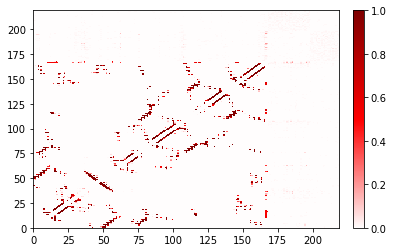

In [14]:
# do we get a familiar-looking residue map?
fig, ax = freq.residue_contacts.plot()

### "Atom slicing"

One of the internal tricks to improve performance is that we take the MDTraj trajectory that has been provided, and shrink it down to only the atoms that are included in the `query` and `haystack`. We refer to this as "atom slicing" (following terminology from MDTraj, although for performance reasons we actually implement it internally).

In most cases, you will want to atom slice. However, there are some cases where atom slicing can slow down your analysis -- mainly if the atoms needed for the contact map are *almost* all the atoms in the trajectory. For this, you can turn atom slicing off.

In [15]:
# use all the atoms except atom 0
used_atoms = list(range(1, topology.n_atoms))

In [16]:
%%time
# with atom slicing
frame_contacts = ContactFrequency(traj[0], query=used_atoms,
                                  haystack=used_atoms)

CPU times: user 410 ms, sys: 3.98 ms, total: 414 ms
Wall time: 251 ms


In [17]:
# disable atom slicing
ContactFrequency._class_use_atom_slice = False

In [18]:
%%time
# without atom slicing
frame_contacts = ContactFrequency(traj[0], query=used_atoms,
                                  haystack=used_atoms)

CPU times: user 245 ms, sys: 8.52 ms, total: 253 ms
Wall time: 95.4 ms


Note that this example is the worst case: the overhead for atom slicing occurs only once for an entire trajectory. However, if you're generating many single-frame contact maps, this could be relevant to you.